## Lecture 6 



### Take Home Exam: 

- We will discuss how to approach the first part of the analysis: exploring the dataset
- We will review some examples and discuss what we expect from students



In [46]:
## Open Data Set 
data <- read.table('./data/data_tr.txt', head = T)[,-1]

First thing to do... Explore the data and the variables

In [49]:
### Visualize the first six rows of the dataset 
head(data)


tw,ira,e401,nifa,inc,hmort,hval,hequity,educ,male,twoearn,nohs,hs,smcol,col,age,fsize,marr
53550,0,0,100,28146,60150,69000,8850,12,0,0,0,1,0,0,31,5,1
124635,0,0,61010,32634,20000,78000,58000,16,0,0,0,0,0,1,52,5,0
192949,1800,0,7549,52206,15900,200000,184100,11,1,1,1,0,0,0,50,3,1
-513,0,0,2487,45252,0,0,0,15,0,1,0,0,1,0,28,4,1
212087,0,0,10625,33126,90000,300000,210000,12,0,0,0,1,0,0,42,3,0
24400,0,0,9000,76860,99600,120000,20400,15,0,1,0,0,1,0,49,6,1


Summary of the variables: 

- Most of the variables are continuous, but many are binaries. Let's explore more how these variables are distributed. 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-502302    3246   25225   63628   82173 1887115 

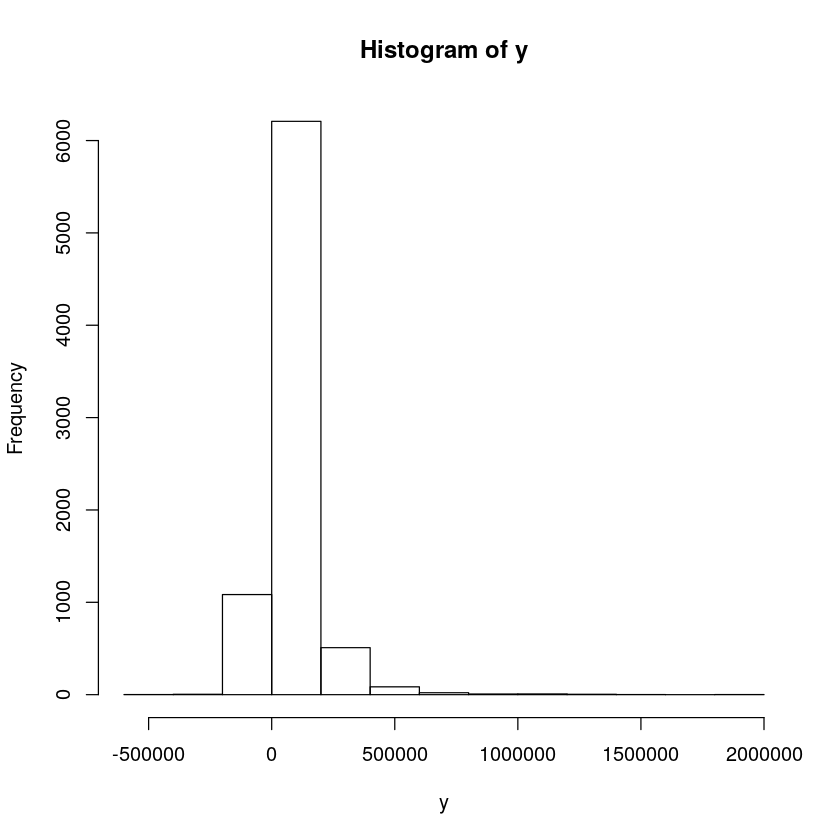

In [42]:
## Outcome 
y <- data$tw
## Visulize the variable in an histogram...
hist(y)

## The variables must first be transformed into numeric! 

summary(y)

### Comments

- The outcome showcases a large support with few points far on to the right
- If we want to implement a predictive model we should take into considerations such a few observations which may drive our results. 

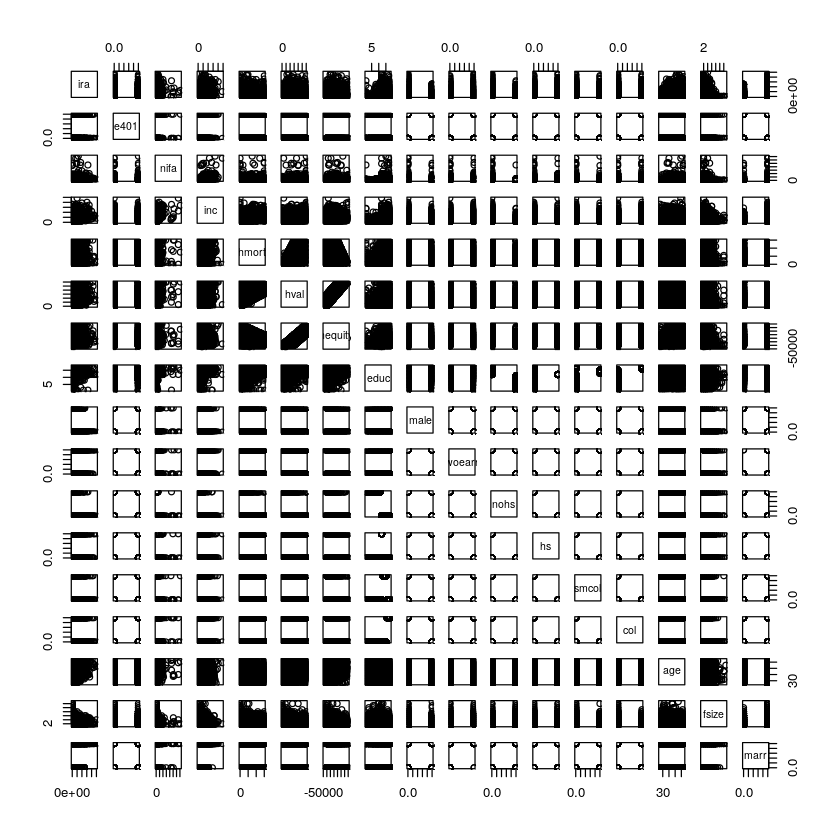

In [14]:
### Explore Covariates 
## Look at the dependence between covariates
pairs(data[,-1])


In [15]:
### Look at summaries (easier to interpert)
summary(data[,-1])

      ira              e401             nifa              inc        
 Min.   :     0   Min.   :0.0000   Min.   :      0   Min.   :    -9  
 1st Qu.:     0   1st Qu.:0.0000   1st Qu.:    200   1st Qu.: 19413  
 Median :     0   Median :0.0000   Median :   1687   Median : 31575  
 Mean   :  3471   Mean   :0.3714   Mean   :  13611   Mean   : 37177  
 3rd Qu.:     0   3rd Qu.:1.0000   3rd Qu.:   8875   3rd Qu.: 48615  
 Max.   :100000   Max.   :1.0000   Max.   :1425115   Max.   :242124  
     hmort             hval           hequity            educ     
 Min.   :     0   Min.   :     0   Min.   :-40000   Min.   : 1.0  
 1st Qu.:     0   1st Qu.:     0   1st Qu.:     0   1st Qu.:12.0  
 Median :  8000   Median : 50000   Median : 10000   Median :12.0  
 Mean   : 30207   Mean   : 63965   Mean   : 33757   Mean   :13.2  
 3rd Qu.: 52000   3rd Qu.: 95000   3rd Qu.: 48000   3rd Qu.:15.0  
 Max.   :150000   Max.   :300000   Max.   :300000   Max.   :18.0  
      male           twoearn            n

### Comments 

- Some variables look suspicious: what about ira? What do you notice?
- Some dummies look imbalanced, see for example nohs
- Other comments? 
- How can this observation help for selecting the variables? 


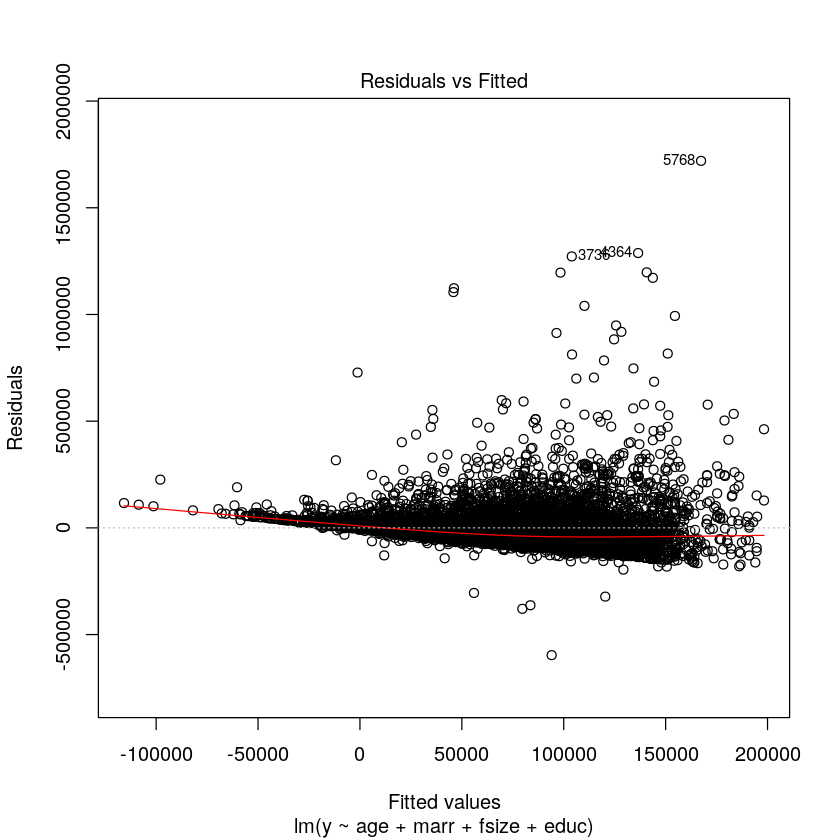

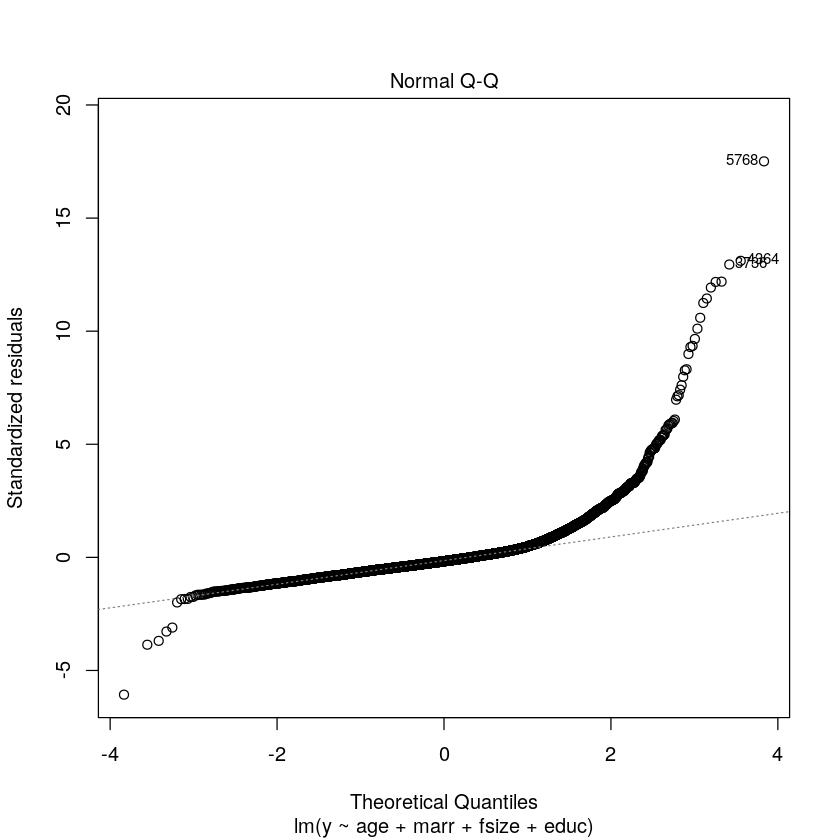

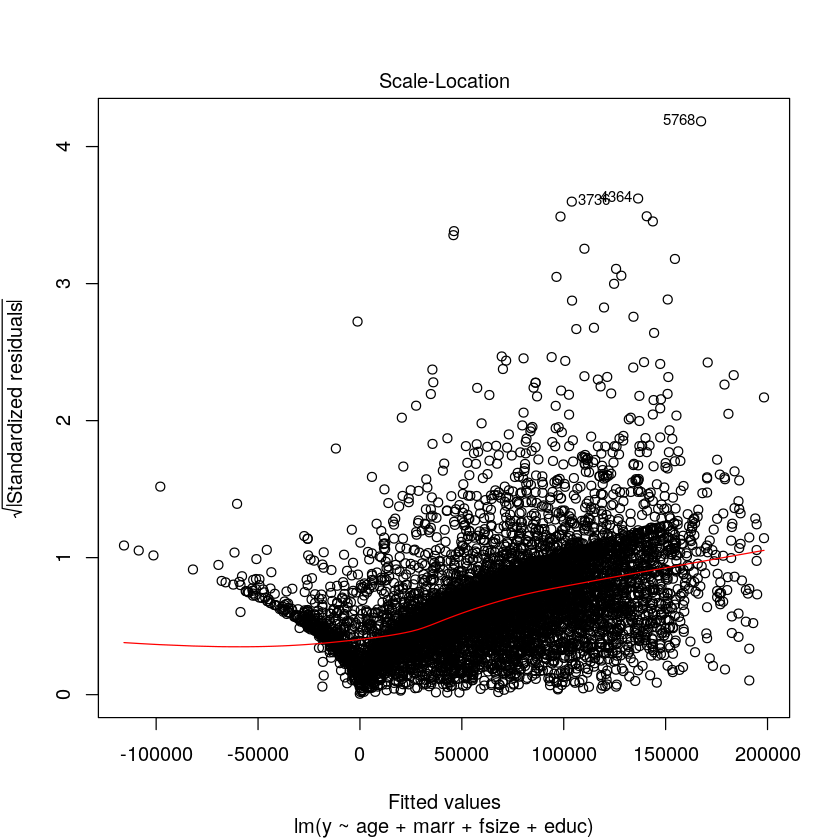

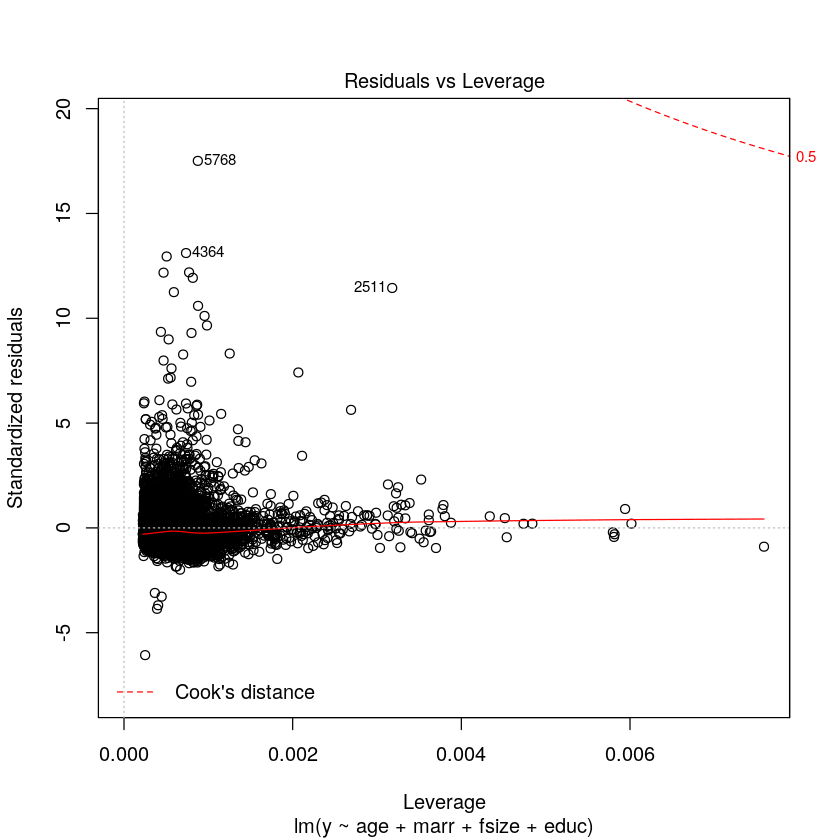

In [17]:
## Try a simple regression 

first_regression <- lm(y ~ age + marr  + fsize + educ, data= data)
## Look at the plots
plot(first_regression)

### Comments:

- Comments on:

- Q-Q Plot
- Outliers
- Quality of the linear fit

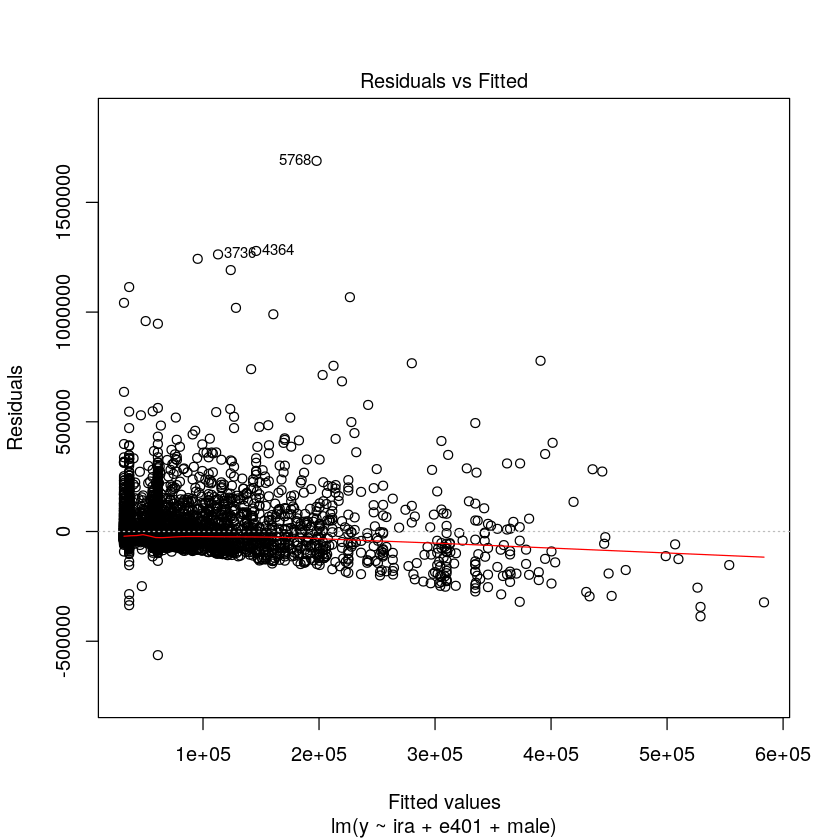

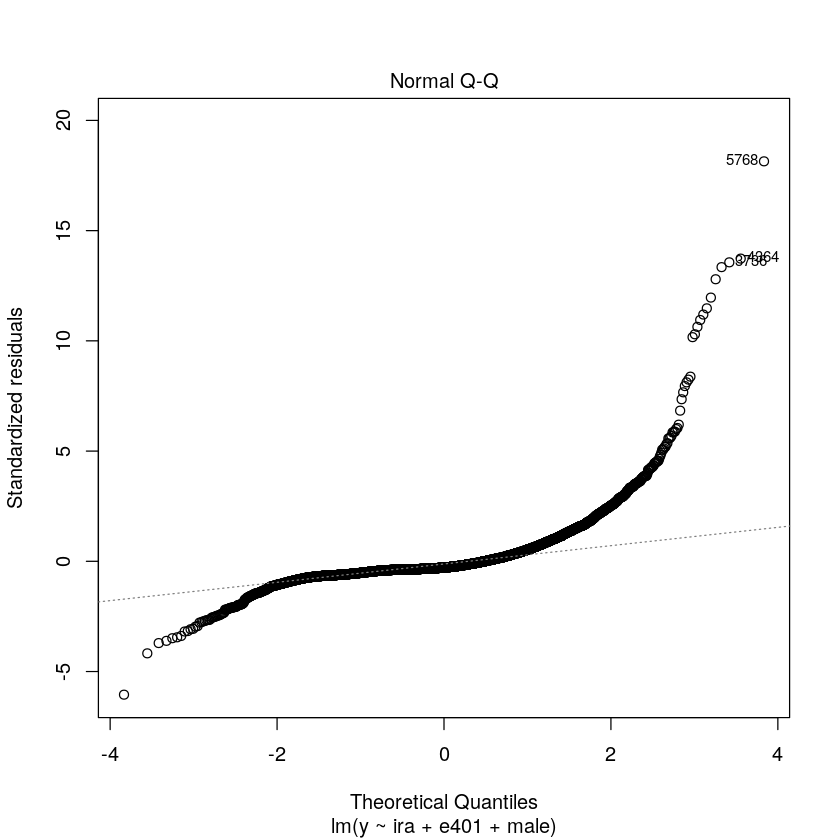

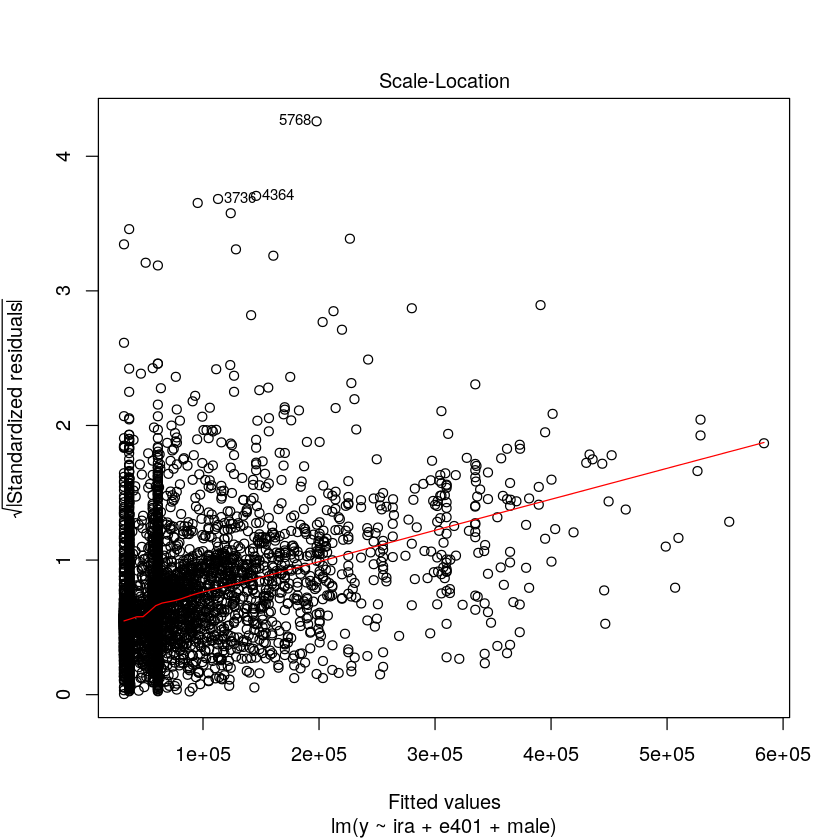

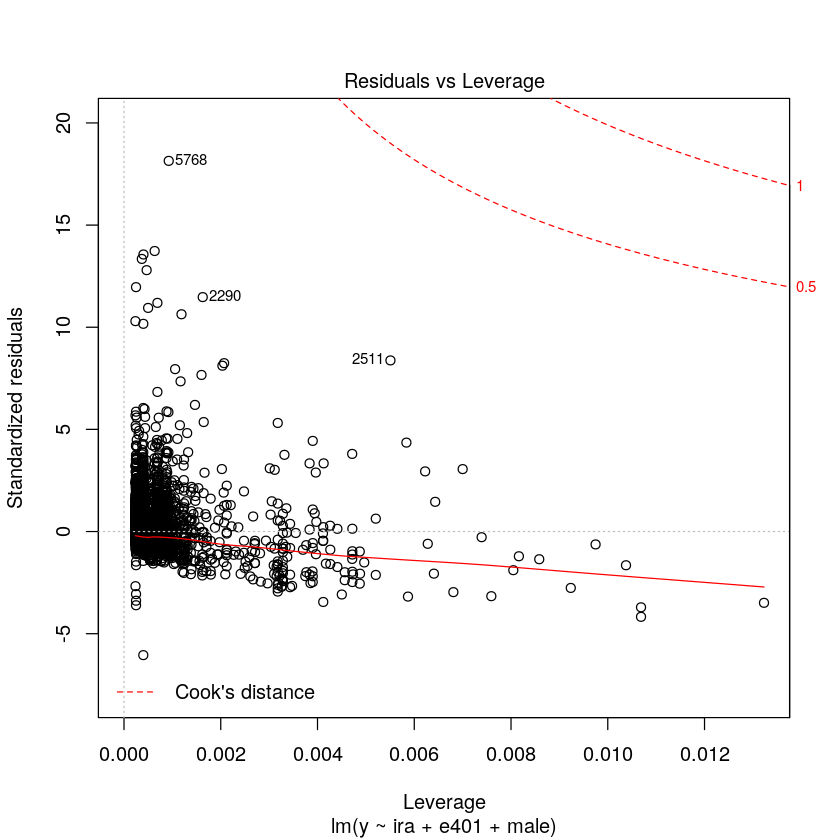

In [19]:
## Try a second regression

first_regression <- lm(y ~ ira + e401 + male, data= data)
## Look at the plots
plot(first_regression)


- Similar conclusions to before 
- What can be done?
- Change Model
- Add quadratic terms
- Remove some of the outliers from the regression

In [23]:
### Another example with quadratic terms 
## For example we may run
my_third_regression <- lm(y ~ ira + ira**2 + e401 + male, data = data)


- Use any visualization tool you can to understand which variables to include
- We want you to **think** and to **justify** your choices; 

- Use cross validation **as well as** other model selection criteria in the choice of your variables

- Think out of the box: feel free to use also other methods than the ones discussed in class, as long as such methods are justified by **critical thinking**. 



### Example 1: Comparing Different Models

- In this example we compare step wise and Ridge Regression



In [30]:
library(MASS)
library(glmnet)

n <- length(y)
k <- 5
ii <- sample(rep(1:k, length= n))
pr.stepwise_backward <- pr.stepwise_forward <- pr.lasso <- pr.ridge <- rep(NA, length(y))

for (j in 1:k){
    
  hold <- (ii == j)
  train <- (ii != j)
  ## Stepwise 
  full <- lm(tw ~ ., data=data[train,])
  null <- lm(tw ~ 1, data=data[train,])
  a <- stepAIC(null, scope=list(lower=null, upper=full), direction='forward')
  # backward stepwise - AIC
  b <- stepAIC(full, scope=list(lower=null, upper=full), direction='backward')
  pr.stepwise_backward[hold] <- predict(b, newdata=data[hold,])
  pr.stepwise_forward[hold] <- predict(a, newdata=data[hold,])
  
  ## Do with lass (we use X and y defined above)
  xx.tr <- data[train,-1]
  y.tr <-  y[train]
  xx.te <- data[hold,-1]
  ridge.cv <- cv.glmnet(x=as.matrix(xx.tr), y=y.tr, nfolds=k, alpha=0)
  lasso.cv <- cv.glmnet(x=as.matrix(xx.tr), y=y.tr, nfolds=k, alpha=1)
  pr.lasso[hold] <- predict(lasso.cv, newx=as.matrix(xx.te))
  pr.ridge[hold] <- predict(ridge.cv, newx=as.matrix(xx.te))
  }

mspe_step_backward <- mean((pr.stepwise_backward-y)^2)
mspe_step_forward <- mean((pr.stepwise_forward-y)^2)
mspe.Lasso <- mean((pr.lasso-y)^2)
mspe.ridge <- mean((pr.ridge-y)^2)


Start:  AIC=146841.4
tw ~ 1

          Df  Sum of Sq        RSS    AIC
+ hequity  1 3.8096e+13 3.2959e+13 141968
+ nifa     1 3.4374e+13 3.6681e+13 142647
+ hval     1 3.1159e+13 3.9896e+13 143181
+ ira      1 1.8133e+13 5.2922e+13 144974
+ inc      1 1.6771e+13 5.4284e+13 145135
+ age      1 7.4603e+12 6.3594e+13 146139
+ hmort    1 5.2611e+12 6.5794e+13 146355
+ marr     1 2.3019e+12 6.8753e+13 146634
+ e401     1 1.7249e+12 6.9330e+13 146687
+ educ     1 1.6336e+12 6.9421e+13 146696
+ col      1 1.5418e+12 6.9513e+13 146704
+ nohs     1 6.9568e+11 7.0359e+13 146781
+ twoearn  1 5.0661e+11 7.0548e+13 146798
+ male     1 2.1968e+11 7.0835e+13 146824
+ hs       1 1.4480e+11 7.0910e+13 146830
+ fsize    1 5.2793e+10 7.1002e+13 146839
+ smcol    1 2.8737e+10 7.1026e+13 146841
<none>                  7.1055e+13 146841

Step:  AIC=141968.5
tw ~ hequity

          Df  Sum of Sq        RSS    AIC
+ nifa     1 1.9977e+13 1.2982e+13 136058
+ ira      1 5.6273e+12 2.7332e+13 140782
+ inc      1


Step:  AIC=134964.4
tw ~ ira + e401 + nifa + inc + hmort + hval + educ + male + twoearn + 
    hs + age + marr

          Df  Sum of Sq        RSS    AIC
- educ     1 4.4919e+08 1.0893e+13 134963
- hs       1 6.1538e+08 1.0893e+13 134963
- marr     1 2.3440e+09 1.0895e+13 134964
<none>                  1.0893e+13 134964
- male     1 7.3360e+09 1.0900e+13 134967
- age      1 3.6438e+10 1.0929e+13 134984
- twoearn  1 4.3933e+10 1.0937e+13 134988
- e401     1 7.8444e+10 1.0971e+13 135008
- inc      1 1.8207e+11 1.1075e+13 135068
- ira      1 1.1508e+12 1.2043e+13 135600
- hmort    1 4.6002e+12 1.5493e+13 137198
- nifa     1 1.3709e+13 2.4602e+13 140133
- hval     1 1.4294e+13 2.5186e+13 140282

Step:  AIC=134962.6
tw ~ ira + e401 + nifa + inc + hmort + hval + male + twoearn + 
    hs + age + marr

          Df  Sum of Sq        RSS    AIC
- hs       1 3.8024e+08 1.0894e+13 134961
- marr     1 2.7726e+09 1.0896e+13 134962
<none>                  1.0893e+13 134963
- male     1 7.4367e+09 1


Step:  AIC=135315.6
tw ~ hequity + nifa + ira + inc + e401 + twoearn + age + hmort + 
    male

        Df  Sum of Sq        RSS    AIC
<none>                1.1523e+13 135316
+ marr   1 3518310302 1.1520e+13 135316
+ smcol  1 2177820944 1.1521e+13 135316
+ educ   1 2137984012 1.1521e+13 135316
+ col    1 1707065075 1.1522e+13 135317
+ hs     1  413085592 1.1523e+13 135317
+ nohs   1  367320676 1.1523e+13 135317
+ fsize  1  186402340 1.1523e+13 135317
Start:  AIC=135322.6
tw ~ ira + e401 + nifa + inc + hmort + hval + hequity + educ + 
    male + twoearn + nohs + hs + smcol + col + age + fsize + 
    marr


Step:  AIC=135322.6
tw ~ ira + e401 + nifa + inc + hmort + hval + hequity + educ + 
    male + twoearn + nohs + hs + smcol + age + fsize + marr


Step:  AIC=135322.6
tw ~ ira + e401 + nifa + inc + hmort + hval + educ + male + twoearn + 
    nohs + hs + smcol + age + fsize + marr

          Df  Sum of Sq        RSS    AIC
- smcol    1 2.5848e+07 1.1514e+13 135321
- fsize    1 3.3106e


Step:  AIC=134898.5
tw ~ hequity + nifa + ira + inc

          Df  Sum of Sq        RSS    AIC
+ e401     1 9.0540e+10 1.0717e+13 134847
+ twoearn  1 6.9587e+10 1.0738e+13 134859
+ age      1 6.0890e+10 1.0746e+13 134865
+ male     1 1.3144e+10 1.0794e+13 134893
+ marr     1 1.2919e+10 1.0794e+13 134893
+ fsize    1 9.5433e+09 1.0798e+13 134895
+ hmort    1 3.8645e+09 1.0804e+13 134898
+ hval     1 3.8645e+09 1.0804e+13 134898
<none>                  1.0807e+13 134898
+ smcol    1 9.1686e+08 1.0806e+13 134900
+ hs       1 5.6410e+08 1.0807e+13 134900
+ col      1 2.5806e+08 1.0807e+13 134900
+ nohs     1 2.4174e+08 1.0807e+13 134900
+ educ     1 1.5973e+08 1.0807e+13 134900

Step:  AIC=134847.1
tw ~ hequity + nifa + ira + inc + e401

          Df  Sum of Sq        RSS    AIC
+ twoearn  1 7.7855e+10 1.0639e+13 134803
+ age      1 6.1601e+10 1.0655e+13 134813
+ male     1 1.4457e+10 1.0702e+13 134841
+ marr     1 1.2974e+10 1.0704e+13 134841
+ fsize    1 8.6223e+09 1.0708e+13 134844
<no

Start:  AIC=147085.6
tw ~ 1

          Df  Sum of Sq        RSS    AIC
+ hequity  1 3.9300e+13 3.4284e+13 142240
+ nifa     1 3.7755e+13 3.5830e+13 142520
+ hval     1 3.2496e+13 4.1089e+13 143389
+ ira      1 1.7489e+13 5.6096e+13 145365
+ inc      1 1.7403e+13 5.6181e+13 145375
+ age      1 7.9746e+12 6.5610e+13 146360
+ hmort    1 5.5833e+12 6.8001e+13 146587
+ marr     1 2.3368e+12 7.1248e+13 146883
+ educ     1 1.8300e+12 7.1754e+13 146928
+ e401     1 1.7969e+12 7.1788e+13 146931
+ col      1 1.6212e+12 7.1963e+13 146946
+ nohs     1 7.2952e+11 7.2855e+13 147024
+ twoearn  1 5.5801e+11 7.3026e+13 147039
+ hs       1 1.5247e+11 7.3432e+13 147074
+ fsize    1 1.2939e+11 7.3455e+13 147076
+ male     1 1.1106e+11 7.3473e+13 147078
+ smcol    1 3.6104e+10 7.3548e+13 147084
<none>                  7.3584e+13 147086

Step:  AIC=142240.1
tw ~ hequity

          Df  Sum of Sq        RSS    AIC
+ nifa     1 2.2655e+13 1.1629e+13 135380
+ ira      1 5.1086e+12 2.9176e+13 141218
+ inc      1


Step:  AIC=134209.9
tw ~ ira + e401 + nifa + inc + hmort + hval + educ + male + twoearn + 
    nohs + hs + age + fsize

          Df  Sum of Sq        RSS    AIC
- fsize    1 4.1672e+08 9.6384e+12 134208
- hs       1 7.9419e+08 9.6388e+12 134208
- nohs     1 1.4732e+09 9.6395e+12 134209
<none>                  9.6380e+12 134210
- educ     1 3.6078e+09 9.6416e+12 134210
- male     1 9.7950e+09 9.6478e+12 134214
- age      1 3.1924e+10 9.6699e+12 134229
- twoearn  1 4.5047e+10 9.6830e+12 134237
- e401     1 6.3303e+10 9.7013e+12 134249
- inc      1 1.4360e+11 9.7816e+12 134302
- ira      1 1.1366e+12 1.0775e+13 134915
- hmort    1 4.3345e+12 1.3972e+13 136565
- hval     1 1.4410e+13 2.4048e+13 140011
- nifa     1 1.6512e+13 2.6150e+13 140543

Step:  AIC=134208.2
tw ~ ira + e401 + nifa + inc + hmort + hval + educ + male + twoearn + 
    nohs + hs + age

          Df  Sum of Sq        RSS    AIC
- hs       1 8.2172e+08 9.6392e+12 134207
- nohs     1 1.5486e+09 9.6399e+12 134207
<none>    


Step:  AIC=135526.4
tw ~ hequity + nifa + ira + inc + e401 + twoearn + age

        Df  Sum of Sq        RSS    AIC
+ hmort  1 1.2393e+10 1.1870e+13 135522
+ hval   1 1.2393e+10 1.1870e+13 135522
+ male   1 7.4323e+09 1.1875e+13 135524
<none>                1.1882e+13 135526
+ smcol  1 2.0322e+09 1.1880e+13 135527
+ col    1 1.3310e+09 1.1881e+13 135528
+ educ   1 1.1810e+09 1.1881e+13 135528
+ marr   1 1.0074e+09 1.1881e+13 135528
+ hs     1 8.8038e+07 1.1882e+13 135528
+ fsize  1 4.1917e+05 1.1882e+13 135528
+ nohs   1 4.6420e+03 1.1882e+13 135528

Step:  AIC=135521.8
tw ~ hequity + nifa + ira + inc + e401 + twoearn + age + hmort

        Df  Sum of Sq        RSS    AIC
+ male   1 8681359816 1.1861e+13 135519
<none>                1.1870e+13 135522
+ smcol  1 1755704068 1.1868e+13 135523
+ col    1 1669206444 1.1868e+13 135523
+ educ   1 1561731476 1.1868e+13 135523
+ marr   1  661471919 1.1869e+13 135523
+ fsize  1  101625815 1.1870e+13 135524
+ hs     1   19574477 1.1870e+13 13552

In [31]:
## Check the best
c(mspe_step_backward, mspe_step_forward, mspe.Lasso, mspe.ridge)

[1] 1726670234 1727551419 2016385863 1914568876

In [33]:
## Look at step backward

## Fit on the ENTIRE dataset your solution 
null <- lm(tw ~ 1, data=data)
my_model <- stepAIC(null, scope=list(lower=null, upper=full), direction='forward')
 

Start:  AIC=183920.7
tw ~ 1

          Df  Sum of Sq        RSS    AIC
+ hequity  1 4.9157e+13 4.3766e+13 177950
+ nifa     1 4.6356e+13 4.6567e+13 178442
+ hval     1 4.0754e+13 5.2169e+13 179343
+ ira      1 2.2968e+13 6.9955e+13 181670
+ inc      1 2.2065e+13 7.0858e+13 181772
+ age      1 1.0034e+13 8.2889e+13 183016
+ hmort    1 7.0965e+12 8.5827e+13 183293
+ marr     1 2.9801e+12 8.9943e+13 183664
+ e401     1 2.2962e+12 9.0627e+13 183724
+ educ     1 2.0917e+12 9.0831e+13 183742
+ col      1 1.9874e+12 9.0936e+13 183751
+ nohs     1 8.4446e+11 9.2079e+13 183850
+ twoearn  1 6.6250e+11 9.2261e+13 183866
+ male     1 2.1151e+11 9.2712e+13 183905
+ hs       1 2.1056e+11 9.2713e+13 183905
+ fsize    1 9.1945e+10 9.2831e+13 183915
+ smcol    1 3.4283e+10 9.2889e+13 183920
<none>                  9.2923e+13 183921

Step:  AIC=177949.8
tw ~ hequity

          Df  Sum of Sq        RSS    AIC
+ nifa     1 2.7432e+13 1.6334e+13 170133
+ ira      1 7.0709e+12 3.6695e+13 176554
+ inc      1

### Are we done? 

- No! We should look inside the black box. Can we do further improvements on this model? 

In [39]:
summary(my_model)



Call:
lm(formula = tw ~ hequity + nifa + ira + inc + e401 + twoearn + 
    age + hmort + male, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-515091  -13086   -3165    4735 1278144 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.889e+04  2.208e+03  -8.556  < 2e-16 ***
hequity      1.082e+00  1.055e-02 102.540  < 2e-16 ***
nifa         1.055e+00  9.948e-03 106.100  < 2e-16 ***
ira          1.617e+00  5.491e-02  29.454  < 2e-16 ***
inc          3.122e-01  2.664e-02  11.718  < 2e-16 ***
e401         7.791e+03  1.015e+03   7.679 1.80e-14 ***
twoearn     -6.588e+03  1.108e+03  -5.946 2.86e-09 ***
age          2.999e+02  4.956e+01   6.050 1.51e-09 ***
hmort        3.655e-02  1.359e-02   2.690  0.00716 ** 
male         2.972e+03  1.206e+03   2.465  0.01373 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 41480 on 7923 degrees of freedom
Multiple R-squared:  0.8533,	Adjusted R-squared:  0

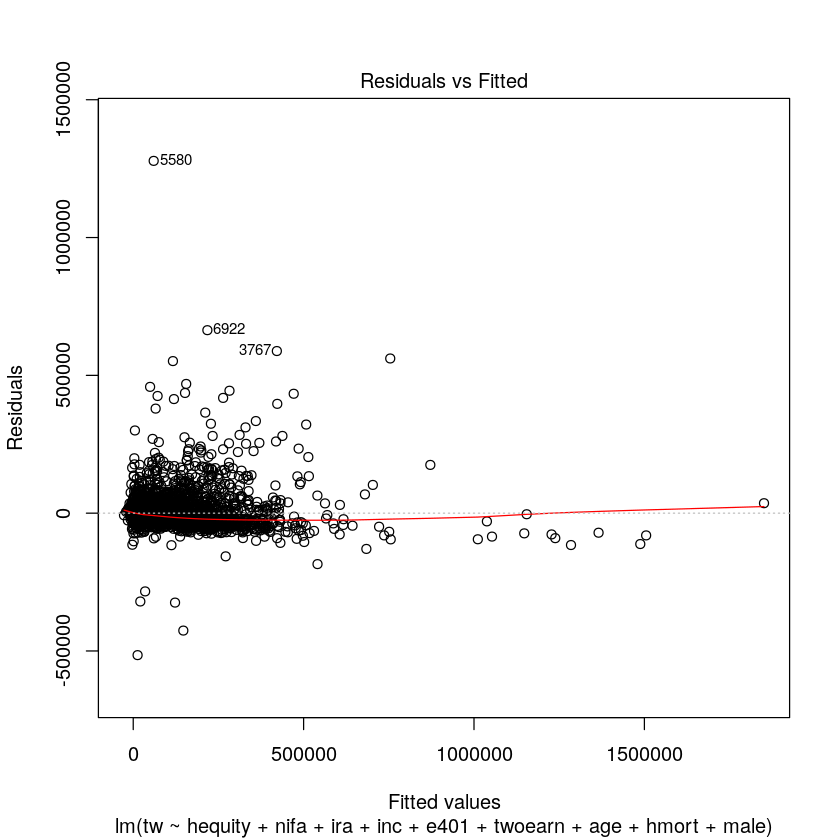

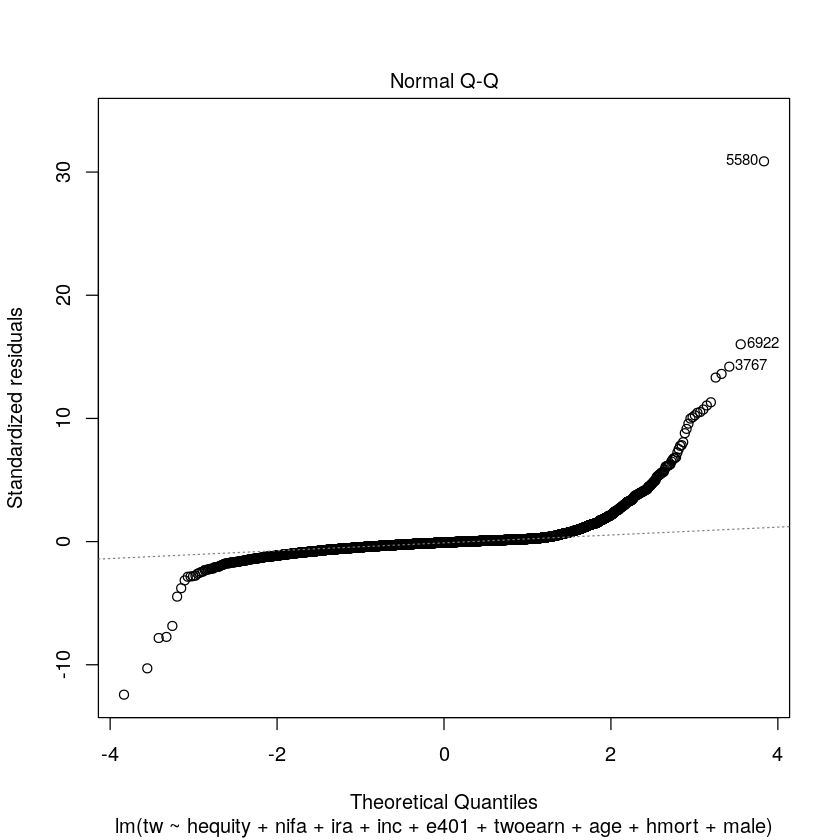

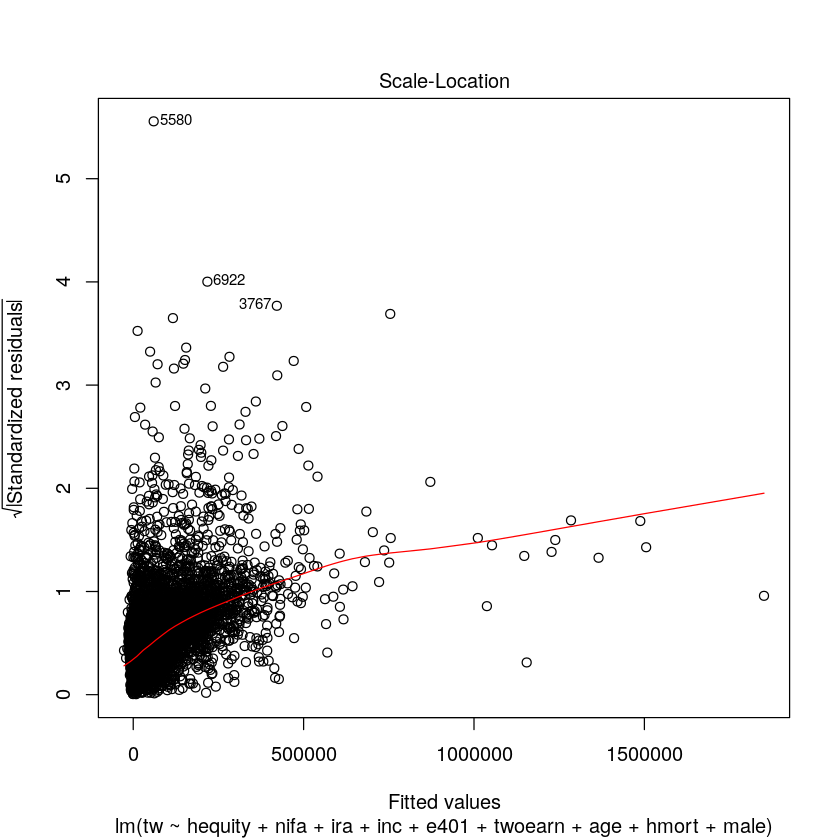

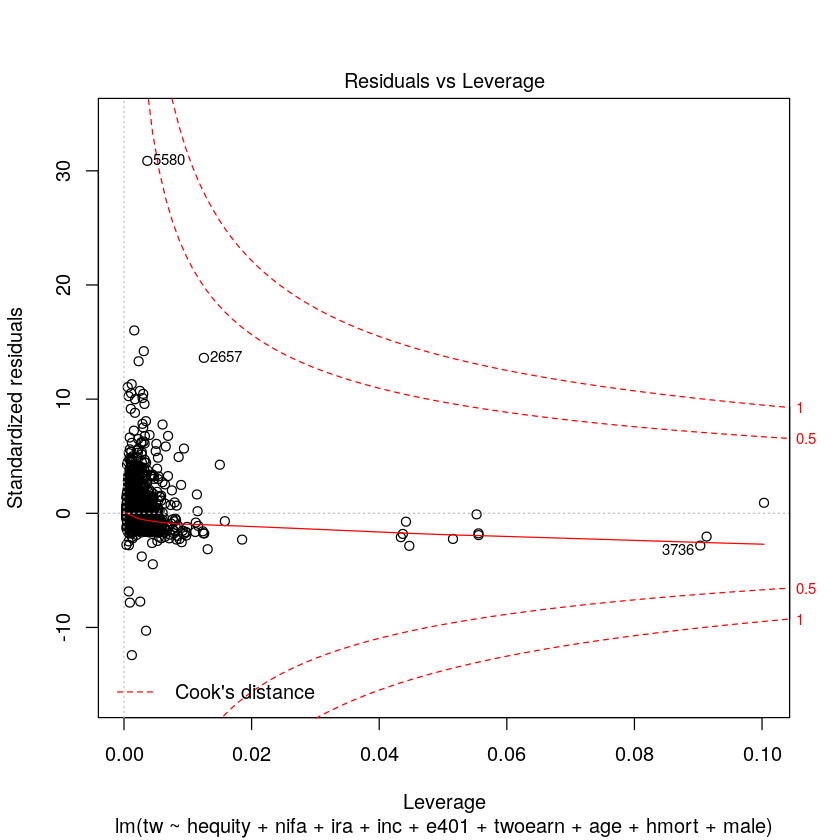

In [35]:
## Study possible outliers 

plot(my_model)

### Optional exercises:

- Remove the observations that you think may be outliers; 
- Compare the prediction error once such observations are removed. What do you observe? 
- Look for a different method that you find in the book and compare the performance. Explain such a method in words. 

### One of the many alternative approaches: Optional and advanced

- We observed that the error follows a distribution with heavy tails. What about modeling such a distribution? 
- We can use what we learn with Bayesian statistics

- **Note**: this is rather advanced and we do not expect you to make such an advanced contribution, but it wants to be an example of what you may do in the future :)

**Idea:**

- We can use a t-student distribution for modeling the distribution of the outcome;
- Internalize the degree of freedom (i.e., the tail behavior) in our parameters; 
- Use a ridge regression (i.e., gaussian prior) for the coefficients. 



In [ ]:
data {

    int<lower=2> N;
    int<lower=1> p;
    vector[N] y;
    matrix[N,p] X;
}


parameters {

    real<lower=0> sig_e;
    real<lower=0> nu;
    real beta0;
    vector[p] beta;
    real<lower=0> lam;
}


model {

    beta ~ normal(0, lam * sig_e);
    nu ~ gamma(2,0.1);
    y ~ student_t(nu, rep_vector(beta0, N) + X * beta, sig_e);
}

In [ ]:
list_data <-list(N = length(y), p = ncol(data[,-1]), X = data[,-1], y = y)

library(rstan)
## fit unpenalized model
model_bayesian <- stan("./additional_programs/model_ridge2.stan", data=list_data)


## Optional

- Explore the model and the fitted values
- Use the information for guiding your choice in the final method that you will use
- Try to make predictions using alternative methods
